<a href="https://colab.research.google.com/github/sahillakhmani/Time-Series-ICICI-bank/blob/main/TSA_ICICIBANK_Presentation_Ashish_Sahil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing necessary libraries

!pip install pmdarima

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.3 MB/s eta 0:00:00


In [ ]:
# Download data for ICICI Bank (using ticker 'ICICIBANK.NS' for NSE)
start_date = '2012-01-01'
end_date = '2024-10-31'

data = yf.download('ICICIBANK.NS', start=start_date, end=end_date, progress=False)
data = data.resample('M').last()  # This is to get the last trading day of each month
data = data[['Close']]
data.dropna(inplace=True)
print(data.head())

Price                            Close
Ticker                    ICICIBANK.NS
Date                                  
2012-01-31 00:00:00+00:00   164.027267
2012-02-29 00:00:00+00:00   164.781815
2012-03-31 00:00:00+00:00   161.854538
2012-04-30 00:00:00+00:00   160.427277
2012-05-31 00:00:00+00:00   142.409088


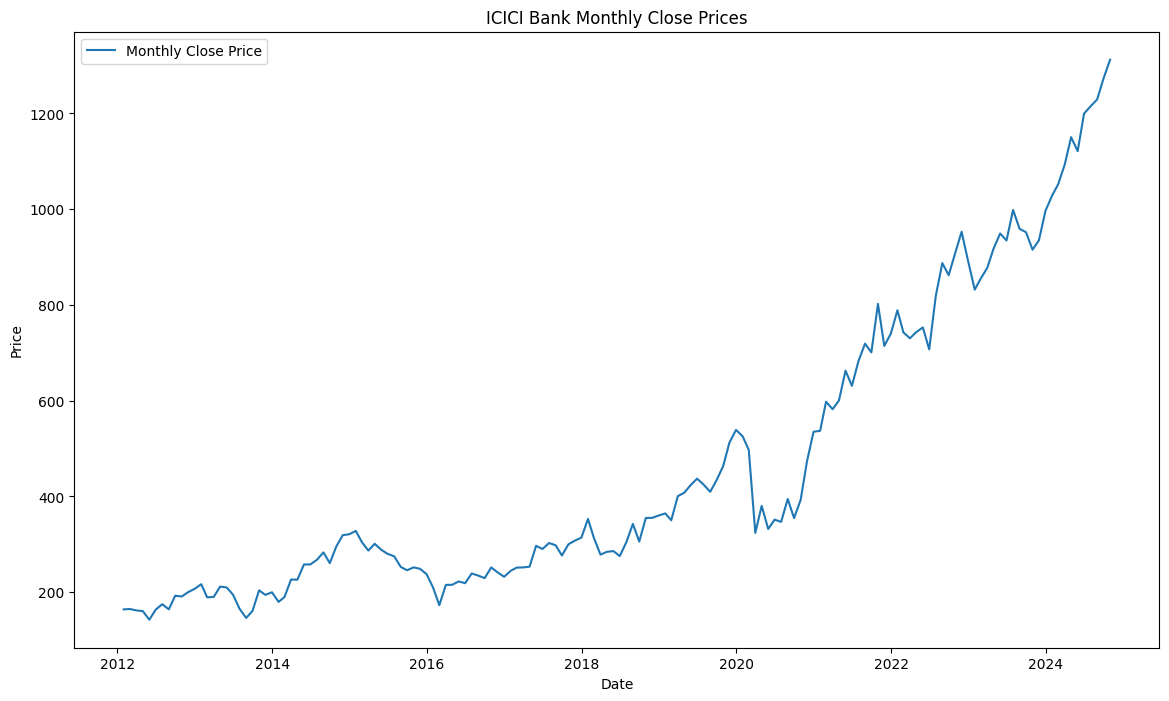

In [ ]:
# Plot of the monthly closing prices
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label='Monthly Close Price')
plt.title('ICICI Bank Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

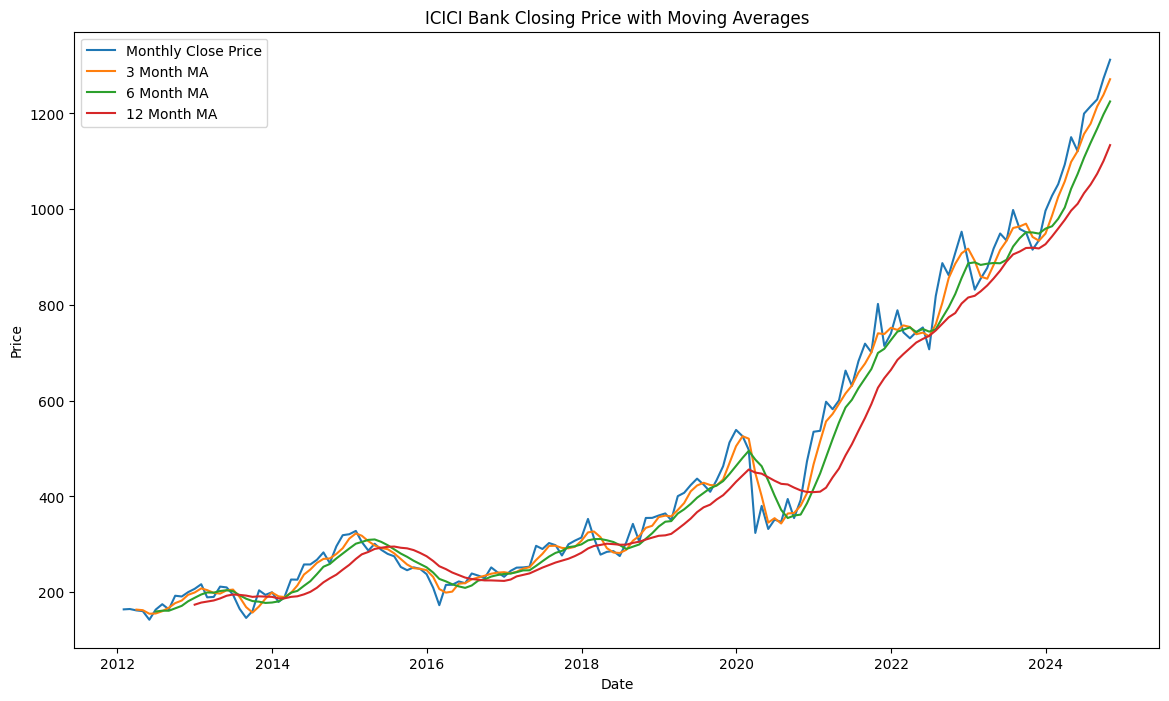

In [ ]:
# Calculate and plot rolling averages (3, 6, 12 months)
data['3_month_MA'] = data['Close'].rolling(window=3).mean()
data['6_month_MA'] = data['Close'].rolling(window=6).mean()
data['12_month_MA'] = data['Close'].rolling(window=12).mean()

plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label='Monthly Close Price')
plt.plot(data['3_month_MA'], label='3 Month MA')
plt.plot(data['6_month_MA'], label='6 Month MA')
plt.plot(data['12_month_MA'], label='12 Month MA')
plt.title('ICICI Bank Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Augmented Dickey-Fuller Test for checking stationarity
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Series is Stationary")
    else:
        print("Series is Non-Stationary")

adf_test(data['Close'])
# Here we will be doing first differencing and then stationarity check
data['Close_diff'] = data['Close'].diff().dropna()
adf_test(data['Close_diff'].dropna())

ADF Statistic: 2.1957653455033173
p-value: 0.9988790026277173
Series is Non-Stationary
ADF Statistic: -13.774036912354227
p-value: 9.564034472009168e-26
Series is Stationary


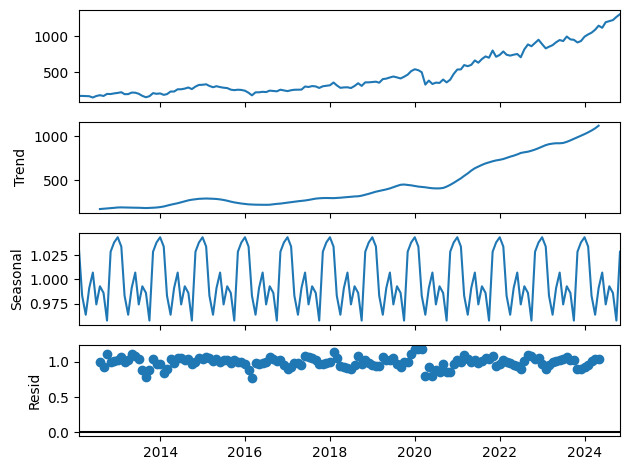

In [ ]:
# Seasonal decomposition of the time series
decompose_result = seasonal_decompose(data['Close'], model='multiplicative', period=12)
decompose_result.plot()
plt.show()

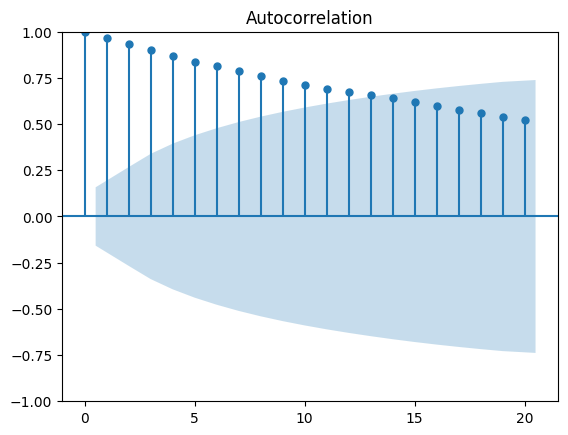

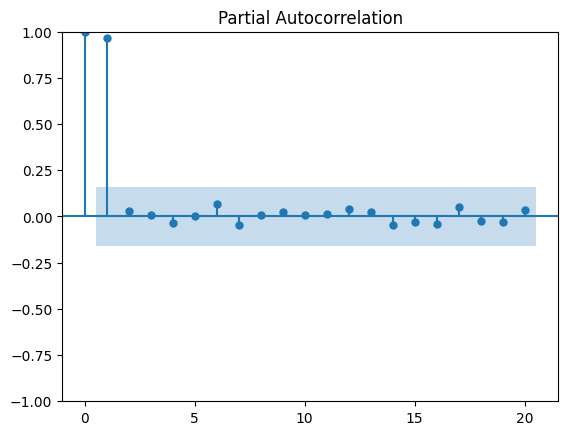

In [ ]:
# Plot ACF and PACF before differencing
plot_acf(data['Close'].dropna(), lags=20)
plt.show()

plot_pacf(data['Close'].dropna(), lags=20)
plt.show()

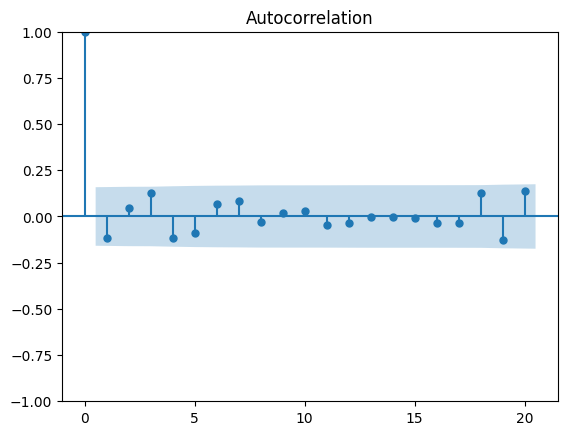

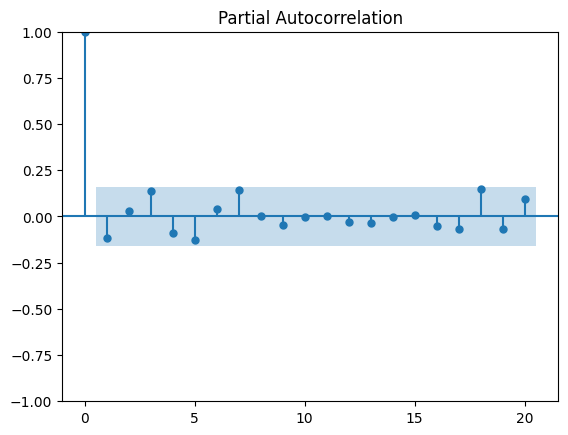

In [ ]:
# Plot ACF and PACF after differencing
plot_acf(data['Close_diff'].dropna(), lags=20)
plt.show()

plot_pacf(data['Close_diff'].dropna(), lags=20)
plt.show()

In [ ]:
# Train-Test Split
train_data = data['Close'][:int(len(data)*0.8)]
test_data = data['Close'][int(len(data)*0.8):]


In [ ]:
# Automatic SARIMA Fitting with Grid Search
from statsmodels.tsa.statespace.sarimax import SARIMAX

def auto_sarima(train_data, seasonal_period=12):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for p in range(3):
        for d in range(2):
            for q in range(3):
                for P in range(3):
                    for D in range(2):
                        for Q in range(3):
                            try:
                                model = SARIMAX(train_data,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, seasonal_period),
                                                enforce_stationarity=False, enforce_invertibility=False)
                                results = model.fit(disp=False)

                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, seasonal_period)
                                    best_model = results
                                    print(f"SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}, AIC: {best_aic}")
                            except:
                                continue
    print(f"\nBest SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}, AIC: {best_aic}")
    return best_model


In [ ]:
# Fit SARIMA with auto selection of best parameters
sarima_model = auto_sarima(train_data)

SARIMA Order: (0, 0, 0), Seasonal Order: (0, 0, 0, 12), AIC: 1791.0682036419664
SARIMA Order: (0, 0, 0), Seasonal Order: (0, 0, 1, 12), AIC: 1551.858386231649
SARIMA Order: (0, 0, 0), Seasonal Order: (0, 0, 2, 12), AIC: 1343.4671796861116
SARIMA Order: (0, 0, 0), Seasonal Order: (0, 1, 1, 12), AIC: 1228.9125906629774
SARIMA Order: (0, 0, 0), Seasonal Order: (0, 1, 2, 12), AIC: 1051.4322646295523
SARIMA Order: (0, 0, 0), Seasonal Order: (1, 1, 2, 12), AIC: 1042.9821807760077
SARIMA Order: (0, 0, 0), Seasonal Order: (2, 1, 2, 12), AIC: 1037.2404039427358
SARIMA Order: (0, 0, 1), Seasonal Order: (0, 1, 2, 12), AIC: 975.5434056553531
SARIMA Order: (0, 0, 1), Seasonal Order: (2, 1, 2, 12), AIC: 972.6543998084152
SARIMA Order: (0, 0, 2), Seasonal Order: (0, 1, 2, 12), AIC: 931.5045893949263
SARIMA Order: (0, 1, 0), Seasonal Order: (0, 1, 2, 12), AIC: 859.3561436022824
SARIMA Order: (0, 1, 0), Seasonal Order: (1, 1, 2, 12), AIC: 858.2035904620568
SARIMA Order: (0, 1, 0), Seasonal Order: (2, 1

In [ ]:
# SARIMA Forecasting
sarima_forecast = sarima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

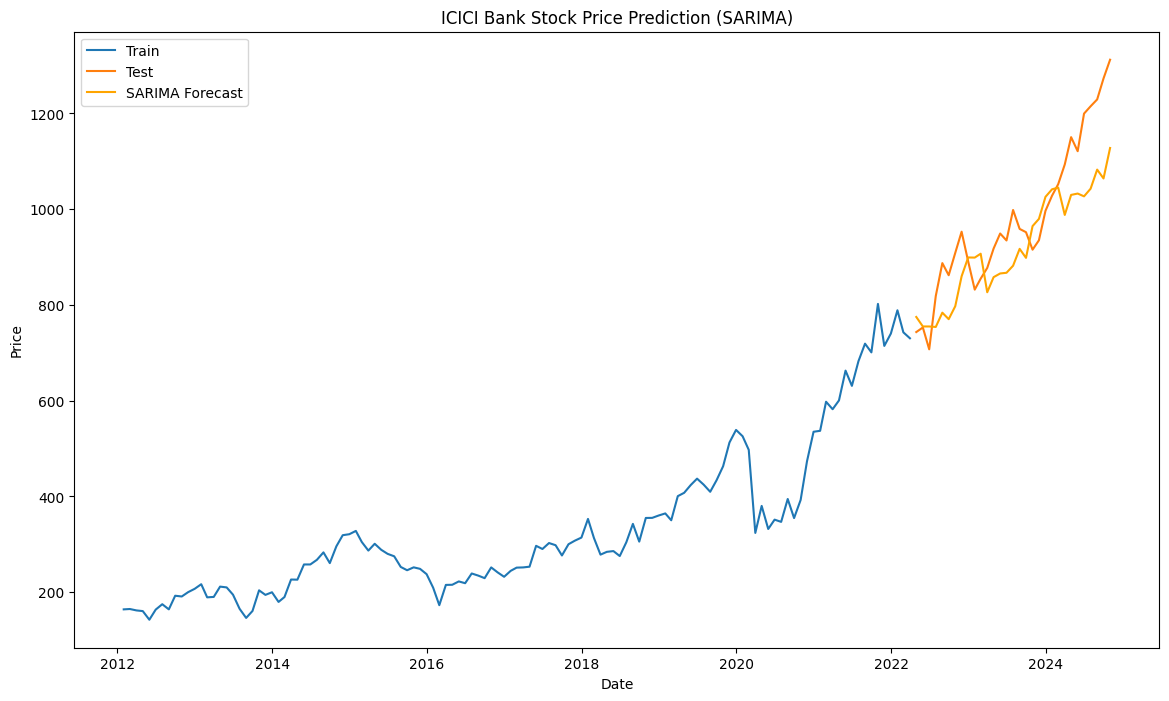

In [ ]:
# Plot SARIMA results
plt.figure(figsize=(14, 8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='orange')
plt.title('ICICI Bank Stock Price Prediction (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE and MAE for SARIMA
sarima_rmse = mean_squared_error(test_data, sarima_forecast, squared=False)
sarima_mae = mean_absolute_error(test_data, sarima_forecast)

print(f'SARIMA RMSE: {sarima_rmse}')
print(f'SARIMA MAE: {sarima_mae}')

SARIMA RMSE: 96.45000722672069
SARIMA MAE: 80.29739362675235


In [ ]:
# Exponential Smoothing (Holt-Winters Method)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def exponential_smoothing(train_data, test_data):
    model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12)
    model_fit = model.fit()

    # Forecasting
    forecast = model_fit.forecast(len(test_data))

    plt.figure(figsize=(14, 8))
    plt.plot(train_data, label='Train')
    plt.plot(test_data, label='Test')
    plt.plot(forecast, label='Exponential Smoothing Forecast', color='green')
    plt.title('Exponential Smoothing Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return forecast


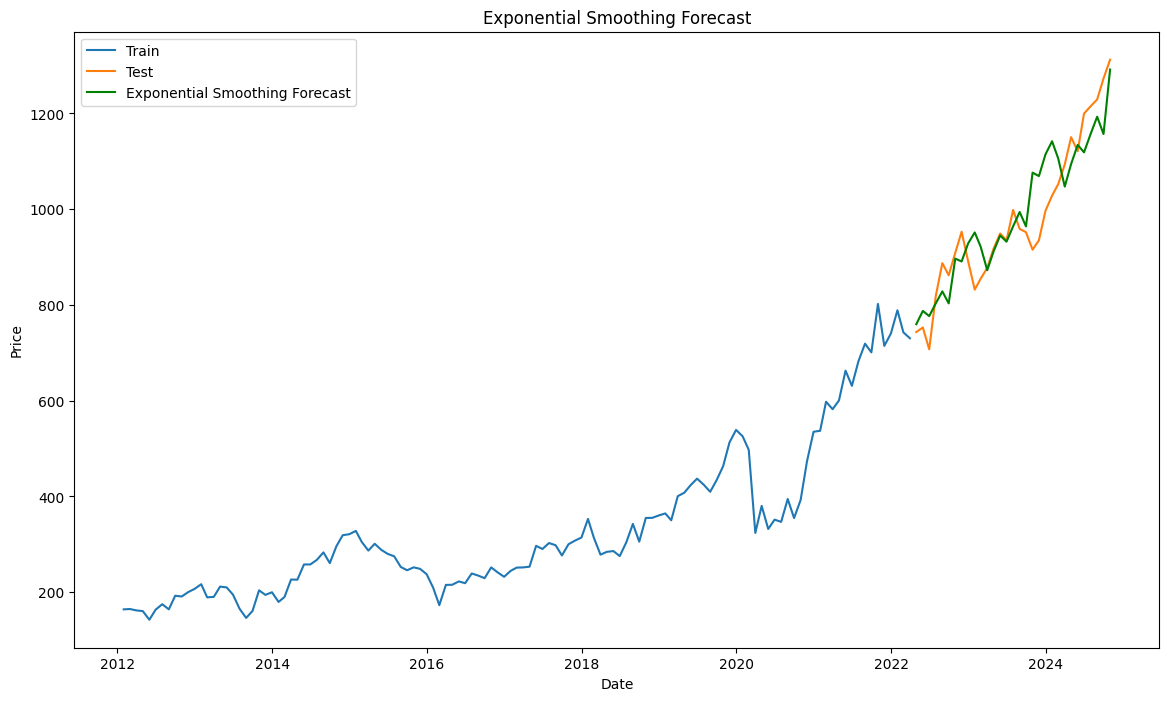

In [ ]:
# Apply Exponential Smoothing Model
exp_smoothing_forecast = exponential_smoothing(train_data, test_data)

In [ ]:
# Calculate RMSE and MAE for Exponential Smoothing
exp_smoothing_rmse = mean_squared_error(test_data, exp_smoothing_forecast, squared=False)
exp_smoothing_mae = mean_absolute_error(test_data, exp_smoothing_forecast)

print(f'Exponential Smoothing RMSE: {exp_smoothing_rmse}')
print(f'Exponential Smoothing MAE: {exp_smoothing_mae}')

Exponential Smoothing RMSE: 68.25822848262408
Exponential Smoothing MAE: 53.48891186556585


In [ ]:
# Comparison of Models
if sarima_rmse < exp_smoothing_rmse:
    print("SARIMA performs better based on RMSE.")
else:
    print("Exponential Smoothing performs better based on RMSE.")

if sarima_mae < exp_smoothing_mae:
    print("SARIMA performs better based on MAE.")
else:
    print("Exponential Smoothing performs better based on MAE.")

Exponential Smoothing performs better based on RMSE.
Exponential Smoothing performs better based on MAE.
